In [1]:
import xarray as xr
#import rioxarray as rxr
import xesmf as xe
import pandas as pd
import numpy as np
import calendar as cld
import matplotlib.pyplot as plt
import matplotlib.colors
colors_land = plt.cm.terrain(np.linspace(0.25, 1, 256))
import proplot as pplt # New plot library (https://proplot.readthedocs.io/en/latest/)
pplt.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
from scipy.stats import chi2
from numba import njit,prange
import matplotlib as mpl
mpl.rcParams['hatch.linewidth'] = 0.05  # previous pdf hatch linewidth
from matplotlib.dates import DateFormatter
import string
from scipy import interpolate
from scipy.stats import linregress

from pyproj import CRS,Transformer,Proj
import time

import sys
sys.path.insert(1, '/home/castelli/Notebooks/PhD/utils') # to include my util file in previous directory
import utils as u
u.check_python_version()

3.10.13 | packaged by conda-forge | (main, Oct 26 2023, 18:07:37) [GCC 12.3.0]


In [2]:
ds = xr.open_dataset('/bettik/beaumetj/MARout/MAR-EC-Earth3/MARgrid_EUe.nc')

imin = 32 ; imax = -30
jmin = 20 ; jmax = -15
lon = np.array(ds.LON[jmin:jmax,imin:imax])
lat = np.array(ds.LAT[jmin:jmax,imin:imax])
H = np.array(ds.SH[jmin:jmax,imin:imax])
nlat,nlon = 91, 139

normal_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True,
                 'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}
big_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':True,
              'lonlines':2, 'latlines':2, 'abc':False, 'latlim':[41.,50],'lonlim':[0.,20.]}
multiplot_format = {'gridlinewidth':0.1, 'gridcolor':'gray8', 'gridalpha':0.5, 'coast':True,'borders':True ,'reso':'hi', 'labels':False, 'lonlines':2,
                    'latlines':2, 'abc':False, 'latlim':[43.,48.5],'lonlim':[4.,16.]}


In [3]:
def detect_alps(H):
    nlat,nlon = np.shape(H)
    mask = np.bool_(np.zeros((nlat,nlon)))
    r = 4
    for j in range(r,nlat-r):
        for i in range(r,nlon-r):
            mask[j,i] = np.logical_and(H[j,i]>360 ,np.any(H[j-r:j+r,i-r:i+r]>1300))
            # mask[j,i] = np.std(H[j-r:j+r,i-r:i+r])>200
    return mask
alps = detect_alps(H)
alps[lon<4.8] = False
alps[np.logical_and(lon>10,lat<45.2)] = False


In [4]:
def mask_by_label(ds, labels, value):
    mask = xr.DataArray(
        labels == value,
        coords={"time": ds.time},
        dims="time"
    )
    return ds.where(mask, drop=True)

In [5]:
def save_precip_by_WT(labels,path,start_yr,end_yr,months,path_out):

    t0 = time.perf_counter()
    
    years = range(start_yr, end_yr+1) # end_yr+1, because of the way "range" works

    path_MBrr = path+'MBrr.{year}.nc'
    path_MBsf = path+'MBsf.{year}.nc'
    files_MBrr = [path_MBrr.format(year=y) for y in years]
    files_MBsf = [path_MBsf.format(year=y) for y in years]

    print("Opening MBrr")
    # open files in dataset
    ds_MBrr = xr.open_mfdataset(files_MBrr, combine="by_coords").isel(y=slice(jmin,jmax),x=slice(imin,imax))
    # select months in chosen season, ex. NDJFM
    ds_MBrr = ds_MBrr.sel(time=ds_MBrr.time.dt.month.isin(months))
    # remove 29th of february to be consistent with labels
    ds_MBrr = ds_MBrr.sel(
        time=~((ds_MBrr.time.dt.month == 2) & (ds_MBrr.time.dt.day == 29))
    )

    t1 = time.perf_counter()
    print(f"Time : {t1 - t0:.3f} s")
    
    print("Opening MBsf")
    ds_MBsf = xr.open_mfdataset(files_MBsf, combine="by_coords").isel(y=slice(jmin,jmax),x=slice(imin,imax))
    ds_MBsf = ds_MBsf.sel(time=ds_MBsf.time.dt.month.isin(months))
    ds_MBsf = ds_MBsf.sel(
        time=~((ds_MBsf.time.dt.month == 2) & (ds_MBsf.time.dt.day == 29))
    )

    t2 = time.perf_counter()
    print(f"Time : {t2 - t0:.3f} s")
    
    # Create precipitation data array
    print("Creating precip data arrays")
    
    da_precip = ds_MBrr["MBrr"] + ds_MBsf["MBsf"]
    
    da_precip_0 = mask_by_label(da_precip, labels, 0)
    da_precip_1 = mask_by_label(da_precip, labels, 1)
    da_precip_2 = mask_by_label(da_precip, labels, 2)
    da_precip_3 = mask_by_label(da_precip, labels, 3)

    t3 = time.perf_counter()
    print(f"Time : {t3 - t0:.3f} s")
    
    print("Creating precip dataset")
    ds_out = xr.Dataset({
        "pr": da_precip,
        "pr0": da_precip_0,
        "pr1": da_precip_1,
        "pr2": da_precip_2,
        "pr3": da_precip_3,
    })
    ds_out["pr"].attrs = da_precip.attrs
    ds_out.attrs["Description"] = "Combined dataset with precipitation (pr), and then masked for each weather type regime (pr0, pr1, pr2, pr3)"

    t4 = time.perf_counter()
    print(f"Time total : {t4 - t0:.3f} s")
    
    print("Saving dataset")
    
    ds_out.to_netcdf(path_out)

    t5 = time.perf_counter()
    print(f"Time total : {t5 - t0:.3f} s")

### MAR-MPI

#### 1980-2009

In [6]:
labels_WT = np.load("/bettik/castelli/data/WTD/MPI/hist/1.0degree/MPI_AtlEurSector_labels_1.0_winter_1980-2009.npy")

In [7]:
labels_WT.shape

(4530,)

In [8]:
save_precip_by_WT(labels = labels_WT,path = '/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/HIST/daily/ICE.MPI-ESM_HIST.EUy.',
                  start_yr = 1980,end_yr = 2009,months = [11, 12, 1, 2, 3],
                  path_out = '/bettik/castelli/data/WTD/MAR/MAR_MPI_precip_weather_types_1980-2009_winter_v2.nc')

Opening MBrr
Time : 13.853 s
Opening MBsf
Time : 39.111 s
Creating precip data arrays
Time : 39.142 s
Creating precip dataset
Time total : 39.200 s
Saving dataset
Time total : 86.529 s


In [73]:
labels_WT = np.load("/bettik/castelli/data/WTD/MPI/hist/1.0degree/MPI_AtlEurSector_labels_1.0_summerJJA_1980-2009.npy")

In [74]:
save_precip_by_WT(labels = labels_WT,path = '/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/HIST/daily/ICE.MPI-ESM_HIST.EUy.',
                  start_yr = 1980,end_yr = 2009,months = [6,7,8],
                  path_out = '/bettik/castelli/data/WTD/MAR/MAR_MPI_precip_weather_types_1980-2009_summerJJA.nc')

Opening MBrr
Time : 4.279 s
Opening MBsf
Time : 10.830 s
Creating precip data arrays
Time : 10.857 s
Creating precip dataset
Time total : 10.890 s
Saving dataset
Time total : 305.461 s


#### 1961-2009

In [6]:
labels_WT = np.load("/bettik/castelli/data/WTD/MPI/hist/1.0degree/MPI_AtlEurSector_labels_1.0_summerJJA_1960-2009.npy")

In [8]:
labels_WT.shape

(4600,)

In [9]:
## MAR simulations start in 1961 so need to remove the labels from 1960
# JJA : 30+31+31=92 days
labels_WT = labels_WT[92:]

labels_WT.shape

(4508,)

In [10]:
save_precip_by_WT(labels = labels_WT,path = '/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/HIST/daily/ICE.MPI-ESM_HIST.EUy.',
                  start_yr = 1961,end_yr = 2009,months = [6,7,8],
                  path_out = '/bettik/castelli/data/WTD/MAR/MAR_MPI_precip_weather_types_1961-2009_summerJJA.nc')

Opening MBrr
Time : 41.018 s
Opening MBsf
Time : 58.239 s
Creating precip data arrays
Time : 58.274 s
Creating precip dataset
Time total : 58.338 s
Saving dataset
Time total : 169.275 s


In [11]:
labels_WT = np.load("/bettik/castelli/data/WTD/MPI/hist/1.0degree/MPI_AtlEurSector_labels_1.0_winter_1960-2009.npy")

In [12]:
labels_WT.shape

(7550,)

In [13]:
## MAR simulations start in 1961 so need to remove the labels from 1960
# NDJFM : 30+31+31+28+31=151 days (labels don't have a 29th of Feb)
labels_WT = labels_WT[151:]

labels_WT.shape

(7399,)

In [14]:
save_precip_by_WT(labels = labels_WT,path = '/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/HIST/daily/ICE.MPI-ESM_HIST.EUy.',
                  start_yr = 1961,end_yr = 2009,months = [11,12,1,2,3],
                  path_out = '/bettik/castelli/data/WTD/MAR/MAR_MPI_precip_weather_types_1961-2009_winter.nc')

Opening MBrr
Time : 7.450 s
Opening MBsf
Time : 41.376 s
Creating precip data arrays
Time : 41.412 s
Creating precip dataset
Time total : 41.459 s
Saving dataset
Time total : 75.144 s


#### 2070-2099 ssp245

In [16]:
labels_WT = np.load("/bettik/castelli/data/WTD/MPI/ssp245/1.0degree/MPI_AtlEurSector_labels_1.0_winter_2070-2099_bis.npy")

In [18]:
save_precip_by_WT(labels = labels_WT,path = '/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/SSP245/daily/ICE.MPI-ESM_SSP245.EUv.',
                  start_yr = 2070,end_yr = 2099,months = [11,12,1,2,3],
                  path_out = '/bettik/castelli/data/WTD/MAR/MAR_MPI_precip_weather_types_ssp245_2070-2099_winter.nc')

Opening MBrr
Time : 17.274 s
Opening MBsf
Time : 36.310 s
Creating precip data arrays
Time : 36.340 s
Creating precip dataset
Time total : 36.383 s
Saving dataset
Time total : 64.389 s


In [19]:
labels_WT = np.load("/bettik/castelli/data/WTD/MPI/ssp245/1.0degree/MPI_AtlEurSector_labels_1.0_summerJJA_2070-2099_bis.npy")

In [20]:
save_precip_by_WT(labels = labels_WT,path = '/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/SSP245/daily/ICE.MPI-ESM_SSP245.EUv.',
                  start_yr = 2070,end_yr = 2099,months = [6,7,8],
                  path_out = '/bettik/castelli/data/WTD/MAR/MAR_MPI_precip_weather_types_ssp245_2070-2099_summerJJA.nc')

Opening MBrr
Time : 10.651 s
Opening MBsf
Time : 13.830 s
Creating precip data arrays
Time : 13.862 s
Creating precip dataset
Time total : 13.902 s
Saving dataset
Time total : 36.842 s


#### 2070-2099 ssp585

In [21]:
labels_WT = np.load("/bettik/castelli/data/WTD/MPI/ssp585/1.0degree/MPI_AtlEurSector_labels_1.0_winter_2070-2099_bis.npy")

In [22]:
save_precip_by_WT(labels = labels_WT,path = '/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/SSP585/daily/ICE.MPI-ESM_SSP585.EUy.',
                  start_yr = 2070,end_yr = 2099,months = [11,12,1,2,3],
                  path_out = '/bettik/castelli/data/WTD/MAR/MAR_MPI_precip_weather_types_ssp585_2070-2099_winter.nc')

Opening MBrr
Time : 35.750 s
Opening MBsf
Time : 80.552 s
Creating precip data arrays
Time : 80.583 s
Creating precip dataset
Time total : 80.625 s
Saving dataset
Time total : 164.697 s


In [23]:
labels_WT = np.load("/bettik/castelli/data/WTD/MPI/ssp585/1.0degree/MPI_AtlEurSector_labels_1.0_summerJJA_2070-2099_bis.npy")

In [24]:
save_precip_by_WT(labels = labels_WT,path = '/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/SSP585/daily/ICE.MPI-ESM_SSP585.EUy.',
                  start_yr = 2070,end_yr = 2099,months = [6,7,8],
                  path_out = '/bettik/castelli/data/WTD/MAR/MAR_MPI_precip_weather_types_ssp585_2070-2099_summerJJA.nc')

Opening MBrr
Time : 6.086 s
Opening MBsf
Time : 12.800 s
Creating precip data arrays
Time : 12.829 s
Creating precip dataset
Time total : 12.867 s
Saving dataset
Time total : 40.349 s


#### 2050-2099 ssp245

In [26]:
labels_WT = np.load("/bettik/castelli/data/WTD/MPI/ssp245/1.0degree/MPI_AtlEurSector_labels_1.0_winter_2050-2099_bis.npy")

In [27]:
save_precip_by_WT(labels = labels_WT,path = '/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/SSP245/daily/ICE.MPI-ESM_SSP245.EUv.',
                  start_yr = 2050,end_yr = 2099,months = [11,12,1,2,3],
                  path_out = '/bettik/castelli/data/WTD/MAR/MAR_MPI_precip_weather_types_ssp245_2050-2099_winter.nc')

Opening MBrr
Time : 28.208 s
Opening MBsf
Time : 36.864 s
Creating precip data arrays
Time : 36.895 s
Creating precip dataset
Time total : 36.942 s
Saving dataset
Time total : 276.809 s


In [28]:
labels_WT = np.load("/bettik/castelli/data/WTD/MPI/ssp245/1.0degree/MPI_AtlEurSector_labels_1.0_summerJJA_2050-2099_bis.npy")

In [29]:
save_precip_by_WT(labels = labels_WT,path = '/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/SSP245/daily/ICE.MPI-ESM_SSP245.EUv.',
                  start_yr = 2050,end_yr = 2099,months = [6,7,8],
                  path_out = '/bettik/castelli/data/WTD/MAR/MAR_MPI_precip_weather_types_ssp245_2050-2099_summerJJA.nc')

Opening MBrr
Time : 32.258 s
Opening MBsf
Time : 37.721 s
Creating precip data arrays
Time : 37.754 s
Creating precip dataset
Time total : 37.797 s
Saving dataset
Time total : 73.679 s


#### 2050-2099 ssp585

In [6]:
labels_WT = np.load("/bettik/castelli/data/WTD/MPI/ssp585/1.0degree/MPI_AtlEurSector_labels_1.0_winter_2050-2099_bis.npy")

In [7]:
save_precip_by_WT(labels = labels_WT,path = '/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/SSP585/daily/ICE.MPI-ESM_SSP585.EUy.',
                  start_yr = 2050,end_yr = 2099,months = [11,12,1,2,3],
                  path_out = '/bettik/castelli/data/WTD/MAR/MAR_MPI_precip_weather_types_ssp585_2050-2099_winter.nc')

Opening MBrr
Time : 14.774 s
Opening MBsf
Time : 25.802 s
Creating precip data arrays
Time : 25.831 s
Creating precip dataset
Time total : 25.891 s
Saving dataset
Time total : 47.252 s


In [8]:
labels_WT = np.load("/bettik/castelli/data/WTD/MPI/ssp585/1.0degree/MPI_AtlEurSector_labels_1.0_summerJJA_2050-2099_bis.npy")

In [9]:
save_precip_by_WT(labels = labels_WT,path = '/bettik/beaumetj/MARout/MAR-MPI-ESM1-2-HR/SSP585/daily/ICE.MPI-ESM_SSP585.EUy.',
                  start_yr = 2050,end_yr = 2099,months = [6,7,8],
                  path_out = '/bettik/castelli/data/WTD/MAR/MAR_MPI_precip_weather_types_ssp585_2050-2099_summerJJA.nc')

Opening MBrr
Time : 5.528 s
Opening MBsf
Time : 11.083 s
Creating precip data arrays
Time : 11.108 s
Creating precip dataset
Time total : 11.138 s
Saving dataset
Time total : 28.039 s


### MAR-ERA5

#### 1980-2009, Beaumet's MAR-ERA5 simulation

In [30]:
labels_WT = np.load("/bettik/castelli/data/WTD/ERA5/hist/1.0degree/ERA5_AtlEurSector_labels_1.0_winter_1980-2009.npy")

In [31]:
save_precip_by_WT(labels = labels_WT,path = '/bettik/beaumetj/MARout/MAR-ERA5/daily/ICE.ERA5_v1.EUl.',
                  start_yr = 1980,end_yr = 2009,months = [11, 12, 1, 2, 3],
                  path_out = '/bettik/castelli/data/WTD/MAR/MARv3.10_ERA5_precip_weather_types_1980-2009_winter.nc')

Opening MBrr
Time : 119.440 s
Opening MBsf
Time : 184.591 s
Creating precip data arrays
Time : 184.621 s
Creating precip dataset
Time total : 184.662 s
Saving dataset
Time total : 214.812 s


In [32]:
labels_WT = np.load("/bettik/castelli/data/WTD/ERA5/hist/1.0degree/ERA5_AtlEurSector_labels_1.0_summerJJA_1980-2009.npy")

In [33]:
save_precip_by_WT(labels = labels_WT,path = '/bettik/beaumetj/MARout/MAR-ERA5/daily/ICE.ERA5_v1.EUl.',
                  start_yr = 1980,end_yr = 2009,months = [6,7,8],
                  path_out = '/bettik/castelli/data/WTD/MAR/MARv3.10_ERA5_precip_weather_types_1980-2009_summerJJA.nc')

Opening MBrr
Time : 7.388 s
Opening MBsf
Time : 14.106 s
Creating precip data arrays
Time : 14.136 s
Creating precip dataset
Time total : 14.175 s
Saving dataset
Time total : 34.572 s


#### 1980-2009, my MAR-ERA5 simulation (MAR v3.14)

In [34]:
labels_WT = np.load("/bettik/castelli/data/WTD/ERA5/hist/1.0degree/ERA5_AtlEurSector_labels_1.0_winter_1980-2009.npy")

In [36]:
save_precip_by_WT(labels = labels_WT,path = '/bettik/castelli/data/MAR-ERA5/MAR3.14/EUo/daily/ICE.ERA5_HIST.EUo.',
                  start_yr = 1980,end_yr = 2009,months = [11, 12, 1, 2, 3],
                  path_out = '/bettik/castelli/data/WTD/MAR/MARv3.14_ERA5_precip_weather_types_1980-2009_winter.nc')

Opening MBrr
Time : 17.455 s
Opening MBsf
Time : 44.360 s
Creating precip data arrays
Time : 44.390 s
Creating precip dataset
Time total : 44.431 s
Saving dataset
Time total : 138.121 s


In [37]:
labels_WT = np.load("/bettik/castelli/data/WTD/ERA5/hist/1.0degree/ERA5_AtlEurSector_labels_1.0_summerJJA_1980-2009.npy")

In [38]:
save_precip_by_WT(labels = labels_WT,path = '/bettik/castelli/data/MAR-ERA5/MAR3.14/EUo/daily/ICE.ERA5_HIST.EUo.',
                  start_yr = 1980,end_yr = 2009,months = [6,7,8],
                  path_out = '/bettik/castelli/data/WTD/MAR/MARv3.14_ERA5_precip_weather_types_1980-2009_summerJJA.nc')

Opening MBrr
Time : 7.069 s
Opening MBsf
Time : 28.837 s
Creating precip data arrays
Time : 28.866 s
Creating precip dataset
Time total : 28.904 s
Saving dataset
Time total : 179.664 s


#### 1961-2009, my MAR-ERA5 simulation (v3.14)

In [7]:
labels_WT = np.load("/bettik/castelli/data/WTD/ERA5/hist/1.0degree/ERA5_AtlEurSector_labels_1.0_winter_1960-2009.npy")

In [9]:
## MAR GCM simulations start in 1961 so need to remove the labels from 1960 (to be homogeneous in years with GCM sims)
# NDJFM : 30+31+31+28+31=151 days (labels don't have a 29th of Feb)
labels_WT = labels_WT[151:]

labels_WT.shape

(7399,)

In [10]:
save_precip_by_WT(labels = labels_WT,path = '/bettik/castelli/data/MAR-ERA5/MAR3.14/EUo/daily/ICE.ERA5_HIST.EUo.',
                  start_yr = 1961,end_yr = 2009,months = [11, 12, 1, 2, 3],
                  path_out = '/bettik/castelli/data/WTD/MAR/MARv3.14_ERA5_precip_weather_types_1961-2009_winter.nc')

Opening MBrr
Time : 5.953 s
Opening MBsf
Time : 10.222 s
Creating precip data arrays
Time : 10.255 s
Creating precip dataset
Time total : 10.316 s
Saving dataset
Time total : 139.102 s


In [21]:
labels_WT = np.load("/bettik/castelli/data/WTD/ERA5/hist/1.0degree/ERA5_AtlEurSector_labels_1.0_summerJJA_1960-2009.npy")

In [22]:
## MAR GCM simulations start in 1961 so need to remove the labels from 1960 (to be homogeneous in years with GCM sims)
# JJA : 30+31+31=92 days
labels_WT = labels_WT[92:]

labels_WT.shape

(4508,)

In [23]:
save_precip_by_WT(labels = labels_WT,path = '/bettik/castelli/data/MAR-ERA5/MAR3.14/EUo/daily/ICE.ERA5_HIST.EUo.',
                  start_yr = 1961,end_yr = 2009,months = [6,7,8],
                  path_out = '/bettik/castelli/data/WTD/MAR/MARv3.14_ERA5_precip_weather_types_1961-2009_summerJJA.nc')

Opening MBrr
Time : 7.081 s
Opening MBsf
Time : 13.022 s
Creating precip data arrays
Time : 13.049 s
Creating precip dataset
Time total : 13.082 s
Saving dataset
Time total : 62.259 s


### MAR-EC-Earth3

#### Winter 1961-2009

In [10]:
labels_WT = np.load("/bettik/castelli/data/WTD/EC-Earth3/hist/1.0degree/EC-Earth3_AtlEurSector_labels_1.0_winter_1960-2009.npy")

## MAR simulations start in 1961 so need to remove the labels from 1960
# NDJFM : 30+31+31+28+31=151 days (labels don't have a 29th of Feb)
labels_WT = labels_WT[151:]

In [12]:
save_precip_by_WT(labels = labels_WT,path = '/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.',
                  start_yr = 1961,end_yr = 2009,months = [11,12,1,2,3],
                  path_out = '/bettik/castelli/data/WTD/MAR/MAR_ECEarth3_precip_weather_types_1961-2009_winter.nc')

Opening MBrr
Time : 11.355 s
Opening MBsf
Time : 24.436 s
Creating precip data arrays
Time : 24.480 s
Creating precip dataset
Time total : 24.519 s
Saving dataset
Time total : 45.589 s


#### SummerJJA 1961-2009

In [14]:
labels_WT = np.load("/bettik/castelli/data/WTD/EC-Earth3/hist/1.0degree/EC-Earth3_AtlEurSector_labels_1.0_summerJJA_1960-2009.npy")

## MAR simulations start in 1961 so need to remove the labels from 1960
# JJA : 30+31+31=92 days
labels_WT = labels_WT[92:]

In [15]:
save_precip_by_WT(labels = labels_WT,path = '/bettik/beaumetj/MARout/MAR-EC-Earth3/HIST/daily/ICE.EC-Earth3_HIST.EUe.',
                  start_yr = 1961,end_yr = 2009,months = [6,7,8],
                  path_out = '/bettik/castelli/data/WTD/MAR/MAR_ECEarth3_precip_weather_types_1961-2009_summerJJA.nc')

Opening MBrr
Time : 5.484 s
Opening MBsf
Time : 10.917 s
Creating precip data arrays
Time : 10.972 s
Creating precip dataset
Time total : 11.051 s
Saving dataset
Time total : 27.387 s


#### Winter 2050-2099

In [17]:
labels_WT = np.load("/bettik/castelli/data/WTD/EC-Earth3/ssp245/1.0degree/EC-Earth3_AtlEurSector_labels_1.0_winter_2050-2099_bis.npy")


In [18]:
save_precip_by_WT(labels = labels_WT,path = '/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.',
                  start_yr = 2050,end_yr = 2099,months = [11,12,1,2,3],
                  path_out = '/bettik/castelli/data/WTD/MAR/MAR_ECEarth3_precip_weather_types_ssp245_2050-2099_winter.nc')

Opening MBrr
Time : 19.006 s
Opening MBsf
Time : 35.034 s
Creating precip data arrays
Time : 35.062 s
Creating precip dataset
Time total : 35.098 s
Saving dataset
Time total : 56.475 s


#### Summer 2050-2099

In [19]:
labels_WT = np.load("/bettik/castelli/data/WTD/EC-Earth3/ssp245/1.0degree/EC-Earth3_AtlEurSector_labels_1.0_summerJJA_2050-2099_bis.npy")


In [20]:
save_precip_by_WT(labels = labels_WT,path = '/bettik/beaumetj/MARout/MAR-EC-Earth3/SSP245/daily/ICE.EC-Earth3_SSP245.EUe.',
                  start_yr = 2050,end_yr = 2099,months = [6,7,8],
                  path_out = '/bettik/castelli/data/WTD/MAR/MAR_ECEarth3_precip_weather_types_ssp245_2050-2099_summerJJA.nc')

Opening MBrr
Time : 5.748 s
Opening MBsf
Time : 11.407 s
Creating precip data arrays
Time : 11.434 s
Creating precip dataset
Time total : 11.467 s
Saving dataset
Time total : 28.601 s


## Test plot

In [ ]:
ds_precip = xr.open_dataset('/bettik/castelli/data/WTD/MAR/MAR_MPI_precip_weather_types_1980-2009_winter.nc')

/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAxes instead.
  warnings.warn("The `map_projection` keyword argument is "
/home/castelli/.conda/envs/phd_v3/lib/python3.10/site-packages/cartopy/mpl/geoaxes.py:403: UserWarning: The `map_projection` keyword argument is deprecated, use `projection` to instantiate a GeoAx

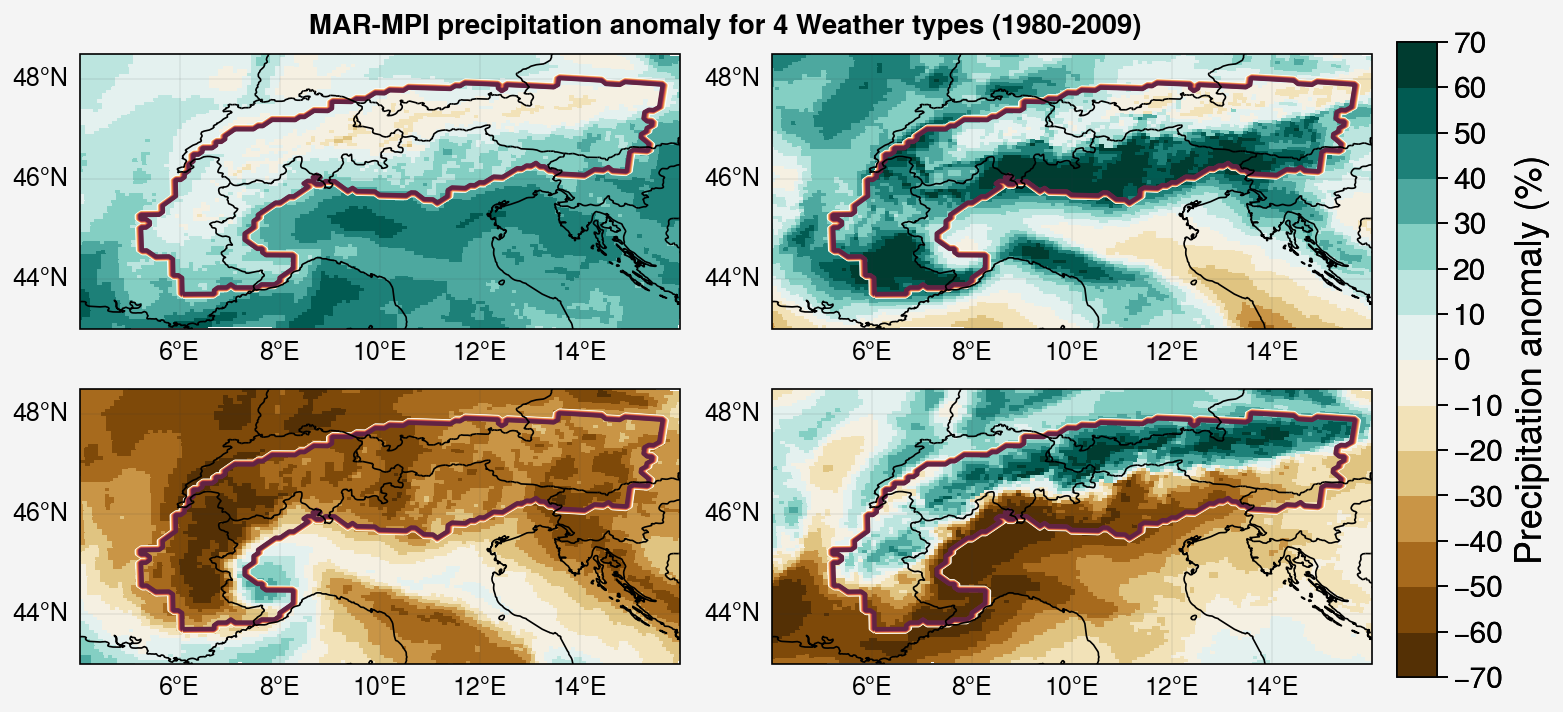

In [66]:
f, axs = pplt.subplots(proj='cyl', axwidth=3,axheight=1.5,ncols=2,nrows=2)

colmap = 'BrBG'
#levels_seas = [np.arange(-15,15,2.5),np.arange(-10,20,2.5),np.arange(-5,35,2.5),np.arange(-10,25,2.5)]
levels_WT = np.arange(-70,80,10)

labels_dataset = ['pr0','pr1','pr2','pr3']

mean_precip = ds_precip['pr'].mean(dim='time')

for lab in range(4):
    m=axs[lab].pcolormesh(lon, lat, 100*(ds_precip[labels_dataset[lab]].mean(dim='time')-mean_precip)/mean_precip, levels=levels_WT,cmap=colmap)
    axs[lab].contour(lon, lat, alps)

f.colorbar(m,label= 'Precipitation anomaly (%)',labelsize='x-large',ticklabelsize='large')

f.format(**normal_format)
f.format(ocean=False,oceancolor='royalblue',reso='hi', latlim=[43.,48.5],lonlim=[4.,16.],suptitle='MAR-MPI precipitation anomaly for 4 Weather types (1980-2009)')